In [1]:
import os
import datautil
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from collections import defaultdict
from scipy import stats

In [2]:
projects, libraries, migrations, rules, dep_changes = datautil.get_data()
print(f"{len(projects)} projects, {len(libraries)} libraries, {len(dep_changes)} dep changes")
print(
    len(dep_changes[dep_changes.type == "add"]), 
    len(dep_changes[dep_changes.type == "rem"]), 
    len(dep_changes[dep_changes.type == "verchg"])
)
print(
    len(set(dep_changes[dep_changes.type == "add"].commit)), 
    len(set(dep_changes[dep_changes.type == "rem"].commit)), 
    len(set(dep_changes[dep_changes.type == "verchg"].commit))
)
print(f"{len(set(dep_changes.commit))} commits with dep chg, {sum(projects.commitsCount)} commits")

19652 projects, 4022 libraries, 2629992 dep changes
1771664 290150 568178
208691 56377 97447
302774 commits with dep chg, 23988437 commits


In [3]:
dep_changes.head()

,project,timestamp,commit,file,type,lib1,lib2,ver1,ver2
0,Snailclimb/JavaGuide,2019-03-25 09:19:36+00:00,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,,commons-codec:commons-codec,,1.8
1,Snailclimb/JavaGuide,2019-03-25 09:19:36+00:00,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,,junit:junit,,4.12
2,Snailclimb/JavaGuide,2019-03-25 09:19:36+00:00,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,,org.bouncycastle:bcprov-jdk15on,,1.56
3,Snailclimb/JavaGuide,2018-07-31 06:49:01+00:00,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,,commons-codec:commons-codec,,1.8
4,Snailclimb/JavaGuide,2018-07-31 06:49:01+00:00,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,,junit:junit,,3.8.1


In [4]:
proj2commits = dict(zip(projects.nameWithOwner, projects.commitsCount))
rule_set = set(zip(rules.fromLib, rules.toLib))
proj_stats = dict()
for proj, df in dep_changes.groupby(["project"]):
    proj_stats[proj] = {
        "project": proj,
        "dependencies": len(datautil.select_project_dependencies(proj)),
        "changes": len(df),
        "adoptions": len(df[df.type == "add"]),
        "removals": len(df[df.type == "rem"]),
        "verchgs": len(df[df.type == "verchg"]),
        "commits": proj2commits[proj],
        "change_commits": len(set(df.commit)),
        "adoption_commits": len(set(df[df.type == "add"].commit)),
        "removal_commits": len(set(df[df.type == "rem"].commit)),
        "verchg_commits": len(set(df[df.type == "verchg"].commit)),
        "possible_migrations": set(),
        "confirmed_migrations": set(),
    }
    for path, df2 in df.groupby(["file"]):
        x = list(zip(df2.commit, df2.type, df2.lib1, df2.lib2))
        for added_lib, removed_lib in itertools.product(set(df2.lib2), set(df2.lib1)):
            if (removed_lib, added_lib) in rule_set:
                proj_stats[proj]["possible_migrations"].add((removed_lib, added_lib))
for idx, row in migrations.iterrows():
    if row["repoName"].replace("_", "/") not in proj_stats:
        continue
    proj_stats[row["repoName"].replace("_", "/")]["confirmed_migrations"].add((row.fromLib, row.toLib))
for proj in proj_stats.keys():
    proj_stats[proj]["possible_migrations"] = len(proj_stats[proj]["possible_migrations"])
    proj_stats[proj]["confirmed_migrations"] = len(proj_stats[proj]["confirmed_migrations"])
proj_stats = pd.DataFrame(proj_stats.values())
proj_stats = proj_stats[(proj_stats.adoptions != 0) & (proj_stats.adoptions >= proj_stats.removals)]
proj_stats.head()

,project,dependencies,changes,adoptions,removals,verchgs,commits,change_commits,adoption_commits,removal_commits,verchg_commits,possible_migrations,confirmed_migrations
0,01org/graphbuilder,8,36,31,1,4,62,3,3,1,2,2,0
1,07kit/07kit,0,20,20,0,0,45,2,2,0,0,0,0
2,0ang3el/HQLi-playground,1,1,1,0,0,5,1,1,0,0,0,0
3,0nise/shell-plus,1,1,1,0,0,8,1,1,0,0,0,0
4,0opslab/opslabJutil,8,15,10,3,2,364,4,2,2,1,1,0


In [5]:
def percent(df, cond) -> str:
    return f"{len(df[cond])} / {len(df)} ({len(df[cond]) / len(df) * 100:.2f}%)"

print("For all projects:")
print(f"{percent(proj_stats, proj_stats.adoptions != 0)} projects with at least one library adoption")
print(f"{percent(proj_stats, proj_stats.removals != 0)} projects with at least one library removal")
print(f"{percent(proj_stats, proj_stats.verchgs != 0)} projects with at least one version change")
print(stats.spearmanr(proj_stats.removals, proj_stats.commits))
print(stats.spearmanr(proj_stats.removals, proj_stats.dependencies))
print(stats.spearmanr(proj_stats.possible_migrations, proj_stats.commits))
print(stats.spearmanr(proj_stats.confirmed_migrations, proj_stats.dependencies))

For all projects:
18254 / 18254 (100.00%) projects with at least one library adoption
8045 / 18254 (44.07%) projects with at least one library removal
8657 / 18254 (47.43%) projects with at least one version change
SpearmanrResult(correlation=0.532596597066869, pvalue=0.0)
SpearmanrResult(correlation=0.15806349002108608, pvalue=1.9607136003858245e-102)
SpearmanrResult(correlation=0.4559899637953487, pvalue=0.0)
SpearmanrResult(correlation=0.07499169337294317, pvalue=3.469125151920879e-24)


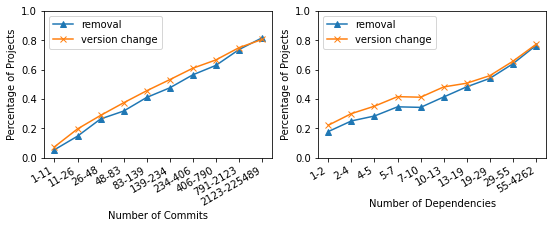

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

splits = np.array_split(proj_stats.sort_values(by="commits"), 10)
ranges = list(map(lambda x: f"{min(x.commits)}-{max(x.commits)}", splits))
rem_rate = list(map(lambda x: len(x[x.removals != 0]) / len(x), splits))
ver_rate = list(map(lambda x: len(x[x.verchgs != 0]) / len(x), splits))
axes[0].plot(ranges, rem_rate, marker="^", label="removal")
axes[0].plot(ranges, ver_rate, marker="x", label="version change")
axes[0].set_xlabel("Number of Commits")
axes[0].set_ylabel("Percentage of Projects")
axes[0].set_ylim(0, 1)
axes[0].legend()

splits = np.array_split(proj_stats[proj_stats.dependencies > 0].sort_values(by="dependencies"), 10)
ranges = list(map(lambda x: f"{min(x.dependencies)}-{max(x.dependencies)}", splits))
rem_rate = list(map(lambda x: len(x[x.removals != 0]) / len(x), splits))
ver_rate = list(map(lambda x: len(x[x.verchgs != 0]) / len(x), splits))
axes[1].plot(ranges, rem_rate, marker="^", label="removal")
axes[1].plot(ranges, ver_rate, marker="x", label="version change")
axes[1].set_xlabel("Number of Dependencies")
axes[1].set_ylabel("Percentage of Projects")
axes[1].set_ylim(0, 1)
axes[1].legend()
fig.autofmt_xdate()
fig.savefig("plots/chgrel.pdf", bbox_inches="tight")

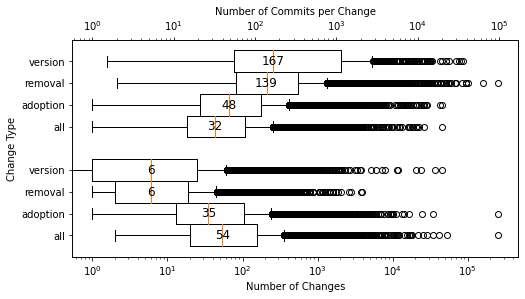

In [7]:
proj_stats_f = proj_stats[proj_stats.removals != 0].copy()

fig, ax = plt.subplots(1, 1, figsize=(8,4))

data = [
    proj_stats_f.changes,
    proj_stats_f.adoptions,
    proj_stats_f.removals,
    proj_stats_f.verchgs,
    proj_stats_f.commits / proj_stats_f.change_commits,
    proj_stats_f.commits / proj_stats_f.adoption_commits,
    proj_stats_f.commits / proj_stats_f.removal_commits,
    proj_stats_f.commits / proj_stats_f.verchg_commits,
]
ax.boxplot(x=data[0:4],
    labels=["all", "adoption", "removal", "version"], 
    positions=[0,0.5,1,1.5], widths=0.5, vert=False)
ax.set_xscale("log")
ax.set_xlabel("Number of Changes")
ax.set_ylabel("Change Type")
ax2 = ax.twiny()
ax2.boxplot(x=data[4:8], labels=["all", "adoption", "removal", "version"], positions=[2.5,3,3.5,4], widths=0.5, vert=False)
ax2.set_xscale("log")
ax2.set_xlabel("Number of Commits per Change")
ax2.set_ylabel("Change Type")
for i, x in enumerate([0,0.5,1,1.5]):
    ax.text(np.median(data[i]), x, str(int(np.median(data[i]))), fontsize=12, horizontalalignment="center", verticalalignment="center")
for i, x in enumerate([2.5,3,3.5,4]):
    ax2.text(np.median(data[i+4]), x, str(int(np.median(data[i+4]))), fontsize=12, horizontalalignment="center", verticalalignment="center")

fig.savefig("plots/chgdis.pdf", bbox_inches="tight")

In [8]:
proj_stats_f["commit_portion_c"] = proj_stats_f.change_commits / proj_stats_f.commits
proj_stats_f["commit_portion_a"] = proj_stats_f.adoption_commits / proj_stats_f.commits
proj_stats_f["commit_portion_r"] = proj_stats_f.removal_commits / proj_stats_f.commits
proj_stats_f["commit_portion_v"] = proj_stats_f.verchg_commits / proj_stats_f.commits
proj_stats_f[["changes", "adoptions", "removals", "verchgs", "commit_portion_c", "commit_portion_a", "commit_portion_r", "commit_portion_v"]].describe()

,changes,adoptions,removals,verchgs,commit_portion_c,commit_portion_a,commit_portion_r,commit_portion_v
count,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000,8045.000000
mean,291.454319,195.645991,31.118086,64.690242,0.058549,0.043371,0.016101,0.017228
std,3098.486307,2893.338193,122.281225,787.996489,0.080021,0.067338,0.028441,0.034250
min,2.000000,1.000000,1.000000,0.000000,0.000051,0.000051,0.000010,0.000000
25%,20.000000,13.000000,2.000000,1.000000,0.013281,0.008488,0.002933,0.000864
50%,54.000000,35.000000,6.000000,6.000000,0.031189,0.020741,0.007194,0.005988
75%,156.000000,105.000000,19.000000,25.000000,0.068966,0.047809,0.017241,0.018117
max,253901.000000,250914.000000,3949.000000,45003.000000,1.000000,1.000000,0.500000,0.655709


In [9]:
rule_libs = set(rules.fromLib) | set(rules.toLib)
rule_projects = set(dep_changes[dep_changes.lib2.isin(rule_libs)].project)
proj_stats_f = proj_stats[proj_stats.project.isin(rule_projects)].copy()
print(len(proj_stats_f), "projects")

print(f"{percent(proj_stats_f, proj_stats_f.removals != 0)} projects with at least one library removal")
print(f"{percent(proj_stats_f, proj_stats_f.possible_migrations != 0)} projects with at least one possible migration")
print(f"{percent(proj_stats_f, proj_stats_f.confirmed_migrations != 0)} projects with at least one confirmed migration")
print(len(proj_stats_f[proj_stats_f.confirmed_migrations > 5]), len(proj_stats_f[proj_stats_f.possible_migrations > 5]))
print(proj_stats_f[proj_stats_f.possible_migrations != 0].possible_migrations.describe())
print(proj_stats_f[proj_stats_f.confirmed_migrations != 0].confirmed_migrations.describe())
data = proj_stats_f[(proj_stats_f.dependencies >= 10) & (proj_stats_f.commits >= 143)]
print(f"{percent(data, data.possible_migrations != 0)} projects with at least one possible migration")
print(f"{percent(data, data.confirmed_migrations != 0)} projects with at least one confirmed migration")

ad, rm, vr = {}, {}, {}
for proj, df in dep_changes.groupby(by="project"):
    chgs = df[df.lib1.isin(rule_libs) | df.lib2.isin(rule_libs)]
    ad[proj] = len(chgs[chgs.type == "add"])
    rm[proj] = len(chgs[chgs.type == "rem"])
    vr[proj] = len(chgs[chgs.type == "verchg"])
proj_stats_f.adoptions = proj_stats_f.project.map(lambda proj: ad[proj])
proj_stats_f.removals = proj_stats_f.project.map(lambda proj: rm[proj])
proj_stats_f.verchgs = proj_stats_f.project.map(lambda proj: vr[proj])

17426 projects
7950 / 17426 (45.62%) projects with at least one library removal
5004 / 17426 (28.72%) projects with at least one possible migration
1564 / 17426 (8.98%) projects with at least one confirmed migration
238 1922
count    5004.000000
mean        9.331934
std        17.298901
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       337.000000
Name: possible_migrations, dtype: float64
count    1564.000000
mean        3.347826
std         4.537382
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        46.000000
Name: confirmed_migrations, dtype: float64
2161 / 3796 (56.93%) projects with at least one possible migration
764 / 3796 (20.13%) projects with at least one confirmed migration


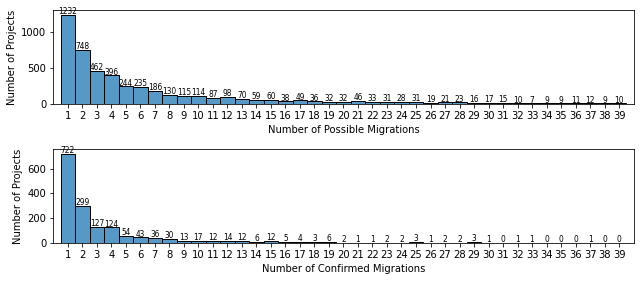

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(9,4))
sns.histplot(data=proj_stats_f[proj_stats_f.possible_migrations > 0], x="possible_migrations", binwidth=1, binrange=[1, 40], ax=axes[0], discrete=True)
sns.histplot(data=proj_stats_f[proj_stats_f.confirmed_migrations > 0], x="confirmed_migrations", binwidth=1, binrange=[1, 40], ax=axes[1], discrete=True)
axes[0].set_ylabel("Number of Projects")
axes[0].set_xlabel("Number of Possible Migrations")
axes[0].set_xlim(0, 40)
axes[0].set_xticks(range(1, 40))
axes[1].set_ylabel("Number of Projects")
axes[1].set_xlabel("Number of Confirmed Migrations")
axes[1].set_xlim(0, 40)
axes[1].set_xticks(range(1, 40))
for i in range(1, 40):
    delta = 8
    count1 = len(proj_stats_f[proj_stats_f.possible_migrations == i])
    axes[0].text(i, count1 + delta, str(count1), fontsize=7.5, horizontalalignment="center")
    count2 = len(proj_stats_f[proj_stats_f.confirmed_migrations == i])
    axes[1].text(i, count2 + delta, str(count2), fontsize=7.5, horizontalalignment="center")
fig.tight_layout()
fig.savefig("plots/migdist.pdf", bbox_inches="tight")

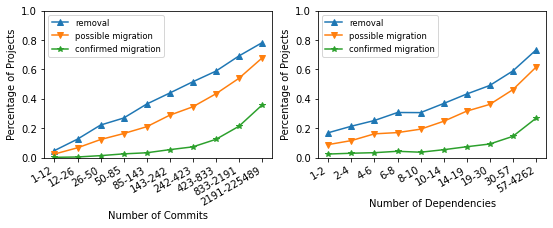

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

splits = np.array_split(proj_stats_f.sort_values(by="commits"), 10)
ranges = list(map(lambda x: f"{min(x.commits)}-{max(x.commits)}", splits))
posmig_rate = list(map(lambda x: len(x[x.possible_migrations != 0]) / len(x), splits))
conmig_rate = list(map(lambda x: len(x[x.confirmed_migrations != 0]) / len(x), splits))
rem_rate = list(map(lambda x: len(x[x.removals != 0]) / len(x), splits))
ver_rate = list(map(lambda x: len(x[x.verchgs != 0]) / len(x), splits))
axes[0].plot(ranges, rem_rate, marker="^", label="removal")
#axes[0].plot(ranges, ver_rate, marker="x", label="version change")
axes[0].plot(ranges, posmig_rate, marker="v", label="possible migration")
axes[0].plot(ranges, conmig_rate, marker="*", label="confirmed migration")
axes[0].set_xlabel("Number of Commits")
axes[0].set_ylabel("Percentage of Projects")
axes[0].set_ylim(0, 1)
axes[0].legend(loc="upper left", fontsize="small")

splits = np.array_split(proj_stats_f[proj_stats_f.dependencies > 0].sort_values(by="dependencies"), 10)
ranges = list(map(lambda x: f"{min(x.dependencies)}-{max(x.dependencies)}", splits))
posmig_rate = list(map(lambda x: len(x[x.possible_migrations != 0]) / len(x), splits))
conmig_rate = list(map(lambda x: len(x[x.confirmed_migrations != 0]) / len(x), splits))
rem_rate = list(map(lambda x: len(x[x.removals != 0]) / len(x), splits))
ver_rate = list(map(lambda x: len(x[x.verchgs != 0]) / len(x), splits))
axes[1].plot(ranges, rem_rate, marker="^", label="removal")
#axes[1].plot(ranges, ver_rate, marker="x", label="version change")
axes[1].plot(ranges, posmig_rate, marker="v", label="possible migration")
axes[1].plot(ranges, conmig_rate, marker="*", label="confirmed migration")
axes[1].set_xlabel("Number of Dependencies")
axes[1].set_ylabel("Percentage of Projects")
axes[1].set_ylim(0, 1)
axes[1].legend(loc="upper left", fontsize="small")
fig.autofmt_xdate()
fig.savefig("plots/migrel.pdf", bbox_inches="tight")

In [12]:
proj_stats_f["retention"] = 1 - proj_stats_f.removals / np.maximum(1, proj_stats_f.adoptions)
proj_stats_f["retention"].describe()

count    17426.000000
mean         0.885636
std          0.210891
min         -3.000000
25%          0.840909
50%          1.000000
75%          1.000000
max          1.000000
Name: retention, dtype: float64

In [13]:
lib_retention = defaultdict(lambda: [0, 0])
for type, lib1, lib2 in zip(dep_changes.type, dep_changes.lib1, dep_changes.lib2):
    if type == "add":
        lib_retention[lib2][1] += 1
    elif type == "rem":
        lib_retention[lib1][0] += 1
libraries["retention"] = libraries.name.map(lambda n: 1 - lib_retention[n][0] / max(1, lib_retention[n][1]))
libraries[libraries.name.isin(dep_changes["lib2"]) & (libraries.retention >= 0)]["retention"].describe()

count    3981.000000
mean        0.764656
std         0.160892
min         0.000000
25%         0.698113
50%         0.803922
75%         0.871972
max         1.000000
Name: retention, dtype: float64

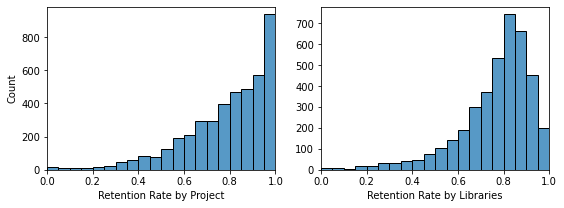

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))
sns.histplot(data=proj_stats_f[proj_stats_f["change_commits"] > 10], x="retention", binwidth=0.05, binrange=(0, 1), ax=axes[0])
axes[0].set_xlabel("Retention Rate by Project")
axes[0].set_xlim(0, 1)
sns.histplot(data=libraries[libraries.name.isin(dep_changes["lib2"])], x="retention", binwidth=0.05, binrange=(0, 1), ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("Retention Rate by Libraries")
axes[1].set_xlim(0, 1)
fig.savefig("plots/retention.pdf", bbox_inches="tight")

In [15]:
def get_retention(lib, timestamp):
    df = dep_changes[dep_changes.timestamp < timestamp].copy()
    df_add, df_rem = df[df.type == "add"], df[df.type == "rem"]
    ret = 1 - len(df_rem[df_rem.lib1 == lib]) / max(1, len(df_add[df_add.lib2 == lib]))
    return ret
with mp.Pool(mp.cpu_count()) as pool:
    fromre = pool.starmap(get_retention, zip(migrations.fromLib, migrations.startCommitTime))
    tore = pool.starmap(get_retention, zip(migrations.toLib, migrations.startCommitTime))

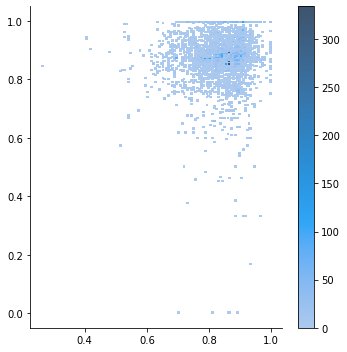

In [16]:
sns.displot(x=fromre, y=tore, cbar=True)